# CAP 4613 Final Project - 3d Object Detection
David Johnston and Elijah Garmon

We started with this https://www.kaggle.com/code/aupurbo392000/lyft-comp
and this https://www.kaggle.com/code/mahmoud1992/ . They're kaggle submissions to the 3d object detection challenge. The first one is the one we decided to use the approach (image segmentation, unet, data formats, etc) from. We borrowed code where applicable (mainly data preprocessing) but made re-implemented the model ourselves using tensorflow instead of pytorch. We used this article as a start for programming unet, but had to make heavy modificiations https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406 .

Yes this code is really messy. It was made to work first then be slightly prettier later.

The powerpoint can be found at https://docs.google.com/presentation/d/1nK-YavcEr39MHdQBNlz72g53eNE43tEZT8-y_Ntphck/edit?usp=sharing


In [ ]:
# Run this code first to makes sure libraries are installed
! pip install lyft-dataset-sdk

# Download and Extract data
This takes a ***really*** long time, probably multiple hours, so sit tight.

In [ ]:
from google.colab import files
print("Upload a kaggle.json to download the data")
files.upload()
! mkdir -p ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 3d-object-detection-for-autonomous-vehicles
! unzip -o 3d-object-detection-for-autonomous-vehicles.zip -d 3d-object-detection-for-autonomous-vehicles
! ln -s /content/3d-object-detection-for-autonomous-vehicles/train_images images
! ln -s /content/3d-object-detection-for-autonomous-vehicles/train_lidar lidar
! ln -s /content/3d-object-detection-for-autonomous-vehicles/train_maps maps
! ln -s /content/3d-object-detection-for-autonomous-vehicles/train_data data

KeyboardInterrupt: 

# Data Preprocessing
This might take 10-30 minutes or so, as it has to generate a lot of images.

We're going to start off with some data exploration, trying to first figure out how to get data out, then just look at what the images look like.

In [ ]:
import os

ARTIFACTS_FOLDER = "./artifacts"
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)

In [ ]:
from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

In [ ]:
import shutil

MAPS_FOLDER = "./maps"
os.makedirs(MAPS_FOLDER, exist_ok=True)

shutil.copy('/content/3d-object-detection-for-autonomous-vehicles/train_maps/map_raster_palo_alto.png', MAPS_FOLDER)
level5data = LyftDataset(data_path='.', json_path='/content/3d-object-detection-for-autonomous-vehicles/train_data', verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 7.6 seconds.
Reverse indexing ...
Done reverse indexing in 2.9 seconds.


In [ ]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]
train_data_folder = os.path.join(ARTIFACTS_FOLDER, "bev_train_data")
validation_data_folder = os.path.join(ARTIFACTS_FOLDER, "bev_validation_data")

In [ ]:
records = [(level5data.get('sample', record['first_sample_token'])['timestamp'], record) for record in level5data.scene]

entries = []

for start_time, record in sorted(records):
    start_time = level5data.get('sample', record['first_sample_token'])['timestamp'] / 1000000

    token = record['token']
    name = record['name']
    date = datetime.utcfromtimestamp(start_time)
    host = "-".join(record['name'].split("-")[:2])
    first_sample_token = record["first_sample_token"]

    entries.append((host, name, date, token, first_sample_token))

df = pd.DataFrame(entries, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])

In [ ]:
host_count_df = df.groupby("host")['scene_token'].count()
print(host_count_df)

host
host-a004    42
host-a005     1
host-a006     3
host-a007    26
host-a008     5
host-a009     9
host-a011    51
host-a012     2
host-a015     6
host-a017     3
host-a101    20
host-a102    12
Name: scene_token, dtype: int64


We're pretty sure a "Host" is a car, so we're selecting a few cars to be our validation cars. One of the kaggle submissions did it this way, and it seemed pretty reasonable.

In [ ]:
validation_hosts = ["host-a007", "host-a008", "host-a009"]

validation_df = df[df["host"].isin(validation_hosts)]
vi = validation_df.index
train_df = df[~df.index.isin(vi)]

print(len(train_df), len(validation_df), "train/validation split scene counts")

140 40 train/validation split scene counts


In [ ]:
sample_token = train_df.first_sample_token.values[0]
sample = level5data.get("sample", sample_token)

sample_lidar_token = sample["data"]["LIDAR_TOP"]
lidar_data = level5data.get("sample_data", sample_lidar_token)
lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)

ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])

# Homogeneous transformation matrix from car frame to world frame.
global_from_car = transform_matrix(ego_pose['translation'],
                                   Quaternion(ego_pose['rotation']), inverse=False)

# Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                    inverse=False)

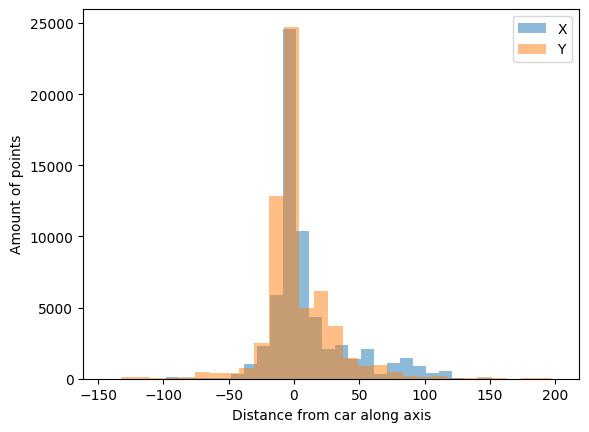

In [ ]:
#lidar_filepath =
lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)


# The lidar pointcloud is defined in the sensor's reference frame.
# We want it in the car's reference frame, so we transform each point
lidar_pointcloud.transform(car_from_sensor)

# A sanity check, the points should be centered around 0 in car space.
plt.hist(lidar_pointcloud.points[0], alpha=0.5, bins=30, label="X")
plt.hist(lidar_pointcloud.points[1], alpha=0.5, bins=30, label="Y")
plt.legend()
plt.xlabel("Distance from car along axis")
plt.ylabel("Amount of points")
plt.show()

In [ ]:
def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.

    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """

    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)

    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size

    tm = tm * np.array(np.hstack((1/voxel_size, [1])))
    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]

# Let's try it with some example values
tm = create_transformation_matrix_to_voxel_space(shape=(100,100,4), voxel_size=(0.5,0.5,0.5), offset=(0,0,0.5))
p = transform_points(np.array([[10, 10, 0, 0, 0], [10, 5, 0, 0, 0],[0, 0, 0, 2, 0]], dtype=np.float32), tm)
print(p)

[[70. 70. 50. 50. 50.]
 [70. 60. 50. 50. 50.]
 [ 3.  3.  3.  7.  3.]]


In [ ]:
def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")

    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)

    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))

    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)

    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count

    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)


voxel_size = (0.4,0.4,1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)

# So that the values in the voxels range from 0,1 we set a maximum intensity.
bev = normalize_voxel_intensities(bev)

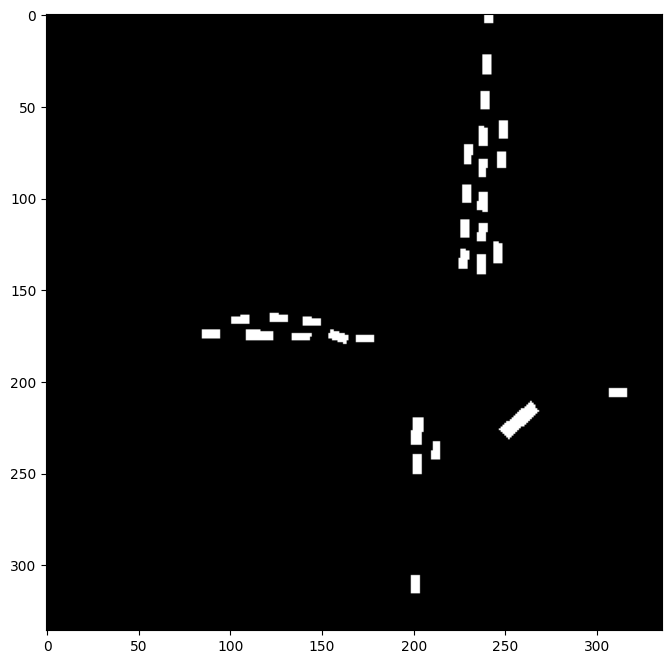

In [ ]:
boxes = level5data.get_boxes(sample_lidar_token)

target_im = np.zeros(bev.shape[:3], dtype=np.uint8)

def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse

    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)

def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1

        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)



move_boxes_to_car_space(boxes, ego_pose)
scale_boxes(boxes, 0.8)
draw_boxes(target_im, voxel_size, boxes, classes, z_offset=z_offset)

plt.figure(figsize=(8,8))
plt.imshow((target_im > 0).astype(np.float32), cmap='Set2')
plt.show()

The above is an image we created from the information describing what bounding boxes are in the scene.

Now that we've explored the data, we're going to prep all of our training data. This is borrowed from one of the kaggle resources, again, but we did get as far as figuring out "how are we going to have to build this" before we decided to check for a code snippet.

In [ ]:
import tqdm.notebook

def prepare_training_data_for_scene(first_sample_token, output_folder, bev_shape, voxel_size, z_offset, box_scale):
    """
    Given a first sample token (in a scene), output rasterized input volumes and targets in birds-eye-view perspective.

    """
    sample_token = first_sample_token

    while sample_token:

        sample = level5data.get("sample", sample_token)

        sample_lidar_token = sample["data"]["LIDAR_TOP"]
        lidar_data = level5data.get("sample_data", sample_lidar_token)
        lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)

        ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])


        global_from_car = transform_matrix(ego_pose['translation'],
                                           Quaternion(ego_pose['rotation']), inverse=False)

        car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                            inverse=False)

        try:
            lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
            lidar_pointcloud.transform(car_from_sensor)
        except Exception as e:
            print ("Failed to load Lidar Pointcloud for {}: {}:".format(sample_token, e))
            sample_token = sample["next"]
            continue

        bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
        bev = normalize_voxel_intensities(bev)


        boxes = level5data.get_boxes(sample_lidar_token)

        target = np.zeros_like(bev)

        move_boxes_to_car_space(boxes, ego_pose)
        scale_boxes(boxes, box_scale)
        draw_boxes(target, voxel_size, boxes=boxes, classes=classes, z_offset=z_offset)

        bev_im = np.round(bev*255).astype(np.uint8)
        target_im = target[:,:,0] # take one channel only

        cv2.imwrite(os.path.join(output_folder, "{}_input.png".format(sample_token)), bev_im)
        cv2.imwrite(os.path.join(output_folder, "{}_target.png".format(sample_token)), target_im)

        sample_token = sample["next"]

NUM_WORKERS=4
box_scale = 0.8

if True:  # set this to false if you already have the data generated.
  for df, data_folder in [(train_df, train_data_folder), (validation_df, validation_data_folder)]:
      print("Preparing data into {} using {} workers".format(data_folder, NUM_WORKERS))
      first_samples = df.first_sample_token.values

      os.makedirs(data_folder, exist_ok=True)

      process_func = partial(prepare_training_data_for_scene,
                            output_folder=data_folder, bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset, box_scale=box_scale)

      pool = Pool(NUM_WORKERS)
      for _ in tqdm.notebook.tqdm(pool.imap_unordered(process_func, first_samples), total=len(first_samples)):
          pass
      pool.close()
      del pool

Now we're going to take the images from the previous snippet and actually load them into datasets. This is kinda annoying due to needing two images, one as input and one as a label. We need to load two separate but related images. So we have tensorflow create an intermediary dataset with the file paths, then map a function to load both images at once to the dataset. What makes this moderately more annoying is tensorflow likes to actually give your function symbolic things instead of just running your function a billion times, hence `tf.strings.split` instead of `.split` .

input (8, 336, 336, 3)
label (8, 336, 336, 1)


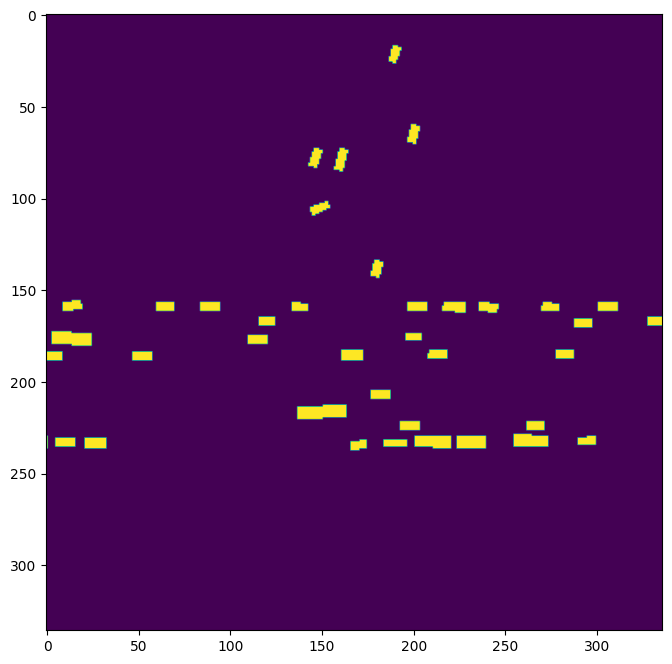

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
import os

def get_data(filepath):
  parts = tf.strings.split(filepath, os.sep)
  filename = parts[-1]
  token = tf.strings.split(filename, "_")[0]
  prefix = tf.strings.reduce_join([parts[0:-1]], axis=-1, separator=os.sep)[0] + os.sep + token

  input_image = tf.io.read_file(prefix + "_input.png")
  input_image = tf.io.decode_png(input_image)
  input_image = tf.image.convert_image_dtype(input_image, tf.float32)
  input_image = tf.image.resize(input_image, [336, 336])

  target_image = tf.io.read_file(prefix + "_target.png")
  target_image = tf.io.decode_png(target_image)
  target_image = tf.image.convert_image_dtype(target_image, tf.float32)
  target_image = tf.image.resize(target_image, [336, 336])

  target_image = tf.cast(target_image > 0.0, tf.float32)

  return input_image, target_image

def build_dataset(dataset_root):
  paths_ds = tf.data.Dataset.list_files(str(dataset_root + '/*_input.png'))
  image_ds = paths_ds.map(get_data).batch(8).prefetch(2)
  return image_ds

train_ds = build_dataset(train_data_folder)
validation_ds = build_dataset(validation_data_folder)

for images, labels in train_ds.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

    print("input",numpy_images.shape)
    print("label",numpy_labels.shape)

plt.figure(figsize=(8,8))
plt.imshow(numpy_labels[0])
plt.show()

# Designing the model


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
import keras
import os

These are the down and up blocks. We got the source for these from an example github/medium article.

In [ ]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
  conv = Conv2D(n_filters,
    3,  # filter size
    activation='relu',
    padding='same',
    kernel_initializer='HeNormal')(inputs)
  conv = Conv2D(n_filters,
    3,   # Kernel size
    activation='relu',
    padding='same',
    kernel_initializer='HeNormal')(conv)

  print("encoder block", inputs, n_filters, dropout_prob, max_pooling)

  conv = BatchNormalization()(conv, training=False)
  if dropout_prob > 0:
    conv = tf.keras.layers.Dropout(dropout_prob)(conv)
  if max_pooling:
    next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
  else:
    next_layer = conv
  skip_connection = conv
  return next_layer, skip_connection


def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
  up = Conv2DTranspose(
    n_filters,
    (2,2),
    strides=(2,2),
    padding='same')(prev_layer_input)

  print("decoder block", prev_layer_input, skip_layer_input, n_filters)

  merge = concatenate([up, skip_layer_input], axis=3)
  conv = Conv2D(n_filters,
    3,
    activation='relu',
    padding='same',
    kernel_initializer='HeNormal')(merge)
  conv = Conv2D(n_filters,
    3,
    activation='relu',
    padding='same',
    kernel_initializer='HeNormal')(conv)
  return conv

This is the final unet network. We originally got most of this code from the medium article and the associated github, but then commented out most of the code that actually built the layers (because it was all statically defined) and replaced it with loops to build the layers.

In [ ]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3, depth=4):
  """
  Combine both encoder and decoder blocks according to the U-Net research paper
  Return the model as output
  """
  # Input size represent the size of 1 image (the size used for pre-processing)
  inputs = Input(input_size)

  # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
  # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
  prev_block = inputs
  blocks = []
  i = 0
  while i < depth - 1:
    d = 0.0
    if i + 1 >= depth - 1:
      d = 0.5
    blocks.append(EncoderMiniBlock(prev_block, n_filters, d, True))
    n_filters *= 2
    prev_block = blocks[-1][0]
    i += 1

  blocks.append(EncoderMiniBlock(prev_block, n_filters, 0.3, False))
  prev_block = blocks[-1][0]

  #cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
  #cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
  #cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
  #cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
  #cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

  while i > 0:
    n_filters //= 2
    i -= 1
    prev_block = DecoderMiniBlock(prev_block, blocks[i][1],  n_filters)

  # Decoder includes multiple mini blocks with decreasing number of filters
  # Observe the skip connections from the encoder are given as input to the decoder
  # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
  #ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
  #ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
  #ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
  #ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

  # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
  # Followed by a 1x1 Conv layer to get the image to the desired size.
  # Observe the number of channels will be equal to number of output classes
  conv9 = Conv2D(n_filters,
    3,
    activation='relu',
    padding='same',
    kernel_initializer='he_normal')(prev_block)

  conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

  # Define the model
  model = tf.keras.Model(inputs=inputs, outputs=conv10)

  return model

Now we build the actual model and print out what shape it has.

In [ ]:
unet = UNetCompiled(input_size=(336,336,3), n_filters=10, n_classes=2, depth=4)
unet.summary()

encoder block KerasTensor(type_spec=TensorSpec(shape=(None, 336, 336, 3), dtype=tf.float32, name='input_6'), name='input_6', description="created by layer 'input_6'") 10 0.0 True
encoder block KerasTensor(type_spec=TensorSpec(shape=(None, 168, 168, 10), dtype=tf.float32, name=None), name='max_pooling2d_15/MaxPool:0', description="created by layer 'max_pooling2d_15'") 20 0.0 True
encoder block KerasTensor(type_spec=TensorSpec(shape=(None, 84, 84, 20), dtype=tf.float32, name=None), name='max_pooling2d_16/MaxPool:0', description="created by layer 'max_pooling2d_16'") 40 0.5 True
encoder block KerasTensor(type_spec=TensorSpec(shape=(None, 42, 42, 40), dtype=tf.float32, name=None), name='max_pooling2d_17/MaxPool:0', description="created by layer 'max_pooling2d_17'") 80 0.3 False
decoder block KerasTensor(type_spec=TensorSpec(shape=(None, 42, 42, 80), dtype=tf.float32, name=None), name='dropout_8/Identity:0', description="created by layer 'dropout_8'") KerasTensor(type_spec=TensorSpec(shape=

Now we need to train it. We add a callback to display a plot of one of the predictions using the most recent form of the model, so that we can make that pretty gif (also display the target and start plots). We set the class weights to under weight 0s as there are a ton of those. We used the same 0.2x as the kaggle, but did try other values and found no change. We found the model learned much slower after like 5 epochs, but was already pretty good by then, so we just did 30 epochs.

In [ ]:
class_weights = {
    0: 0.2,
    1: 1.0,
    2: 1.0,
}

class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
        predicted_value = unet.predict(numpy_images)[0]
        predicted_value = scipy.special.softmax(predicted_value, axis=2)

        #plt.figure(figsize=(8,8))
        #plt.imshow(predicted_value[:,:,0])
        #plt.show()
        plt.figure(figsize=(8,8))
        plt.title(f"Prediction at Epoch {epoch + 1}")
        plt.axis("off")
        plt.imshow(predicted_value[:,:,1])
        plt.show()

optimizer = keras.optimizers.Adam(learning_rate=1e-3)

unet.compile(optimizer=optimizer,
             loss=tf.keras.losses.SparseCategoricalCrossentropy(
                 from_logits=True,
                 reduction="auto"),
             metrics=['accuracy'])

plt.figure(figsize=(8,8))
plt.title(f"Target image")
plt.axis("off")
plt.imshow(numpy_labels[0])
plt.show()

predicted_value = unet.predict(numpy_images)[0]
predicted_value = scipy.special.softmax(predicted_value, axis=2)

#plt.figure(figsize=(8,8))
#plt.imshow(predicted_value[:,:,0])
#plt.show()
plt.figure(figsize=(8,8))
plt.title(f"Prediction at Epoch 0 (Start)")
plt.axis("off")
plt.imshow(predicted_value[:,:,1])
plt.show()

results = unet.fit(train_ds,
                   epochs=30,
                   validation_data=validation_ds,
                   class_weight=class_weights,
                   callbacks=[CustomCallback()])

Output hidden; open in https://colab.research.google.com to view.

Now we're going to display a bunch of plots, just to see how the model is doing.

1.   The class 0 map, this represents where the model thinks there are no cars
2.   The class 1 map, this is where the model thinks there are cars
3.   The class 1 map with a threshold applied, removing "ghosts"
4.   The input data the model was given
5.   The target boxes



1/1 [==============================] - 0s 21ms/step


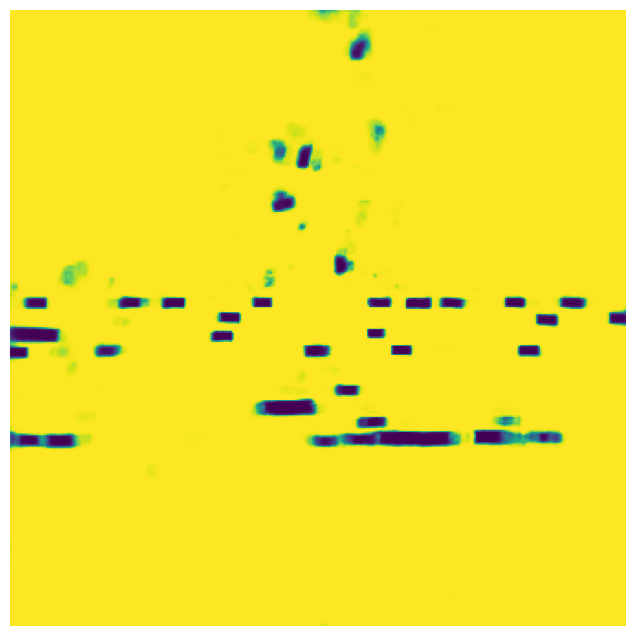

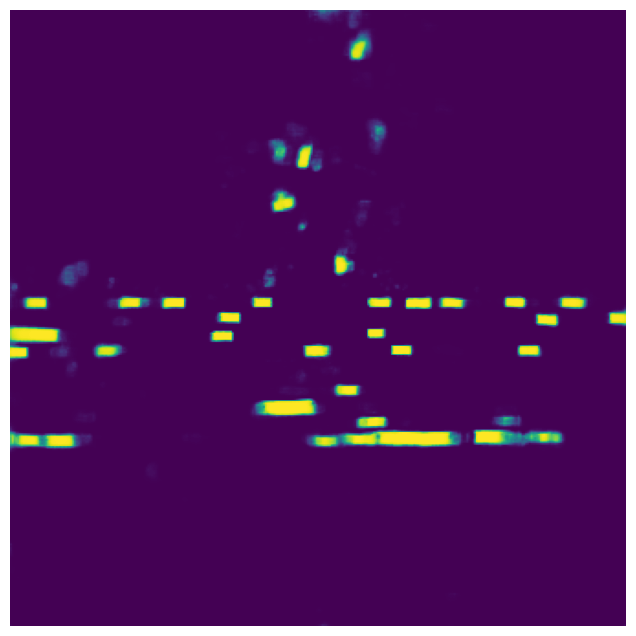

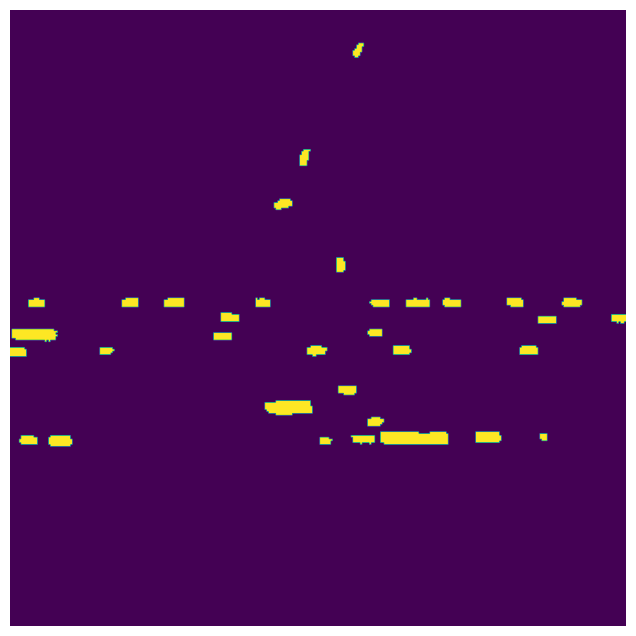

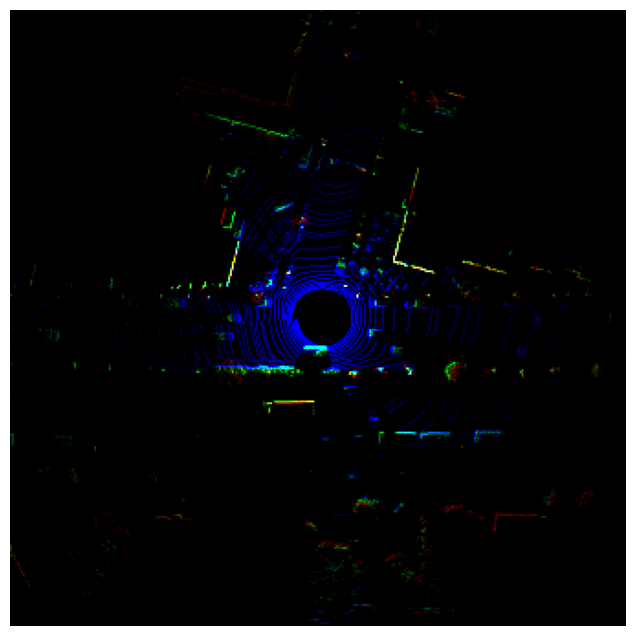

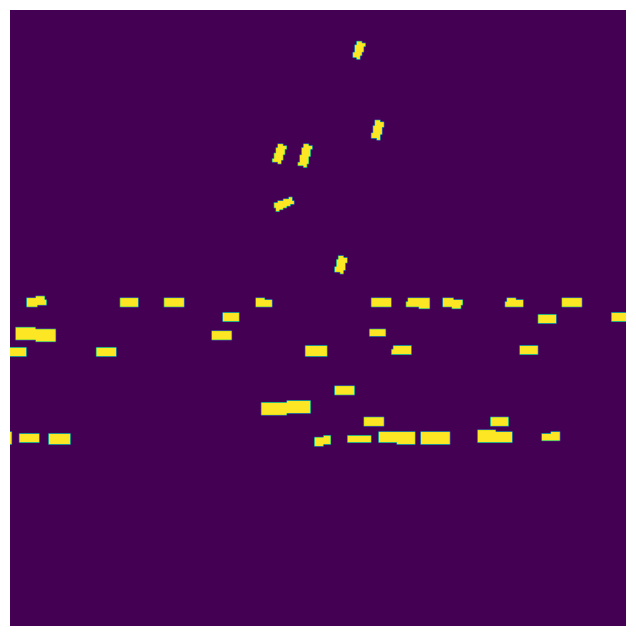

In [ ]:
predicted_value = unet.predict(numpy_images)[0]

predicted_value = scipy.special.softmax(predicted_value, axis=2)

#predicted_value = np.repeat(predicted_value[..., None], 3, axis=2)

plt.figure(figsize=(8,8))
plt.imshow(predicted_value[:,:,0])
plt.axis("off")
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(predicted_value[:,:,1])
plt.axis("off")
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(predicted_value[:,:,1] > 0.9)
plt.axis("off")
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(numpy_images[0])
plt.axis("off")
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(numpy_labels[0])
plt.axis("off")
plt.show()

Now just some loss/accuracy plots

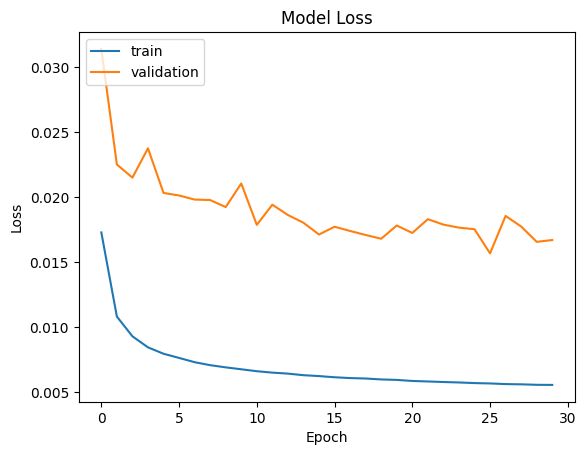

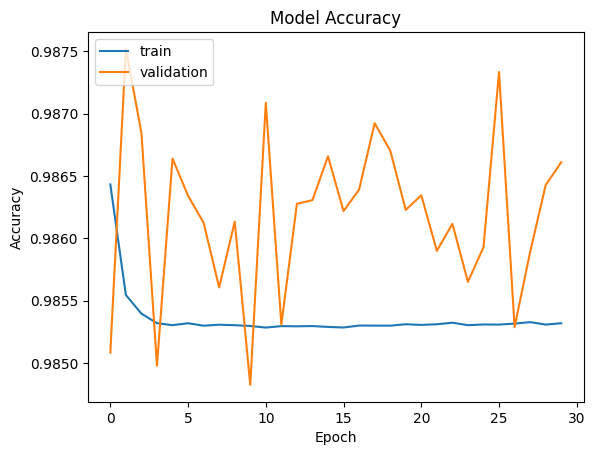

In [ ]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Display a bunch of plots of what the model predicts for a bunch of different inputs, compared to the target. This is good just to get a feel for what mistakes the model is making and to select some nice looking images for the presentation.

In [ ]:
c = 0

for images, labels in validation_ds.take(4):
  val_numpy_images = images.numpy()
  val_numpy_labels = labels.numpy()

  predicted_values = unet.predict(val_numpy_images)

  for i in range(images.shape[0]):
    sample_values = scipy.special.softmax(predicted_values[i], axis=2)

    plt.figure(figsize=(8,8))
    plt.imshow(val_numpy_images[i])
    plt.title(f"Validation Sample {i + 1 + c * 8} Input")
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(8,8))
    plt.imshow(sample_values[:,:,1])
    plt.title(f"Validation Sample {i + 1 + c * 8} Prediction")
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(8,8))
    plt.imshow(sample_values[:,:,1] > 0.9)
    plt.title(f"Validation Sample {i + 1 + c * 8} Threshold")
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(8,8))
    plt.imshow(val_numpy_labels[i])
    plt.title(f"Validation Sample {i + 1 + c * 8} Target")
    plt.axis('off')
    plt.show()

  c += 1

Output hidden; open in https://colab.research.google.com to view.

Next the goal would be to regenerate the box coordinates for so the car can decide what to do. This can be done pretty easily without machine learning using opencv (https://stackoverflow.com/questions/64621016/how-to-calculate-angle-of-a-square-object-with-respect-to-image-in-2d-plane-usin).

This is done by finding the contours in the image then finding the smallest rotated rectangle to cover each contour, both of which are just single function calls. We didn't do this because A) it's not deep learning at that point, B) getting the data from the tensorflow formats into opencv formats will be annoying, and C) displaying the info in colab afterwards will be really annoying.